In [1]:
import numpy as np
import random
import time
import matplotlib.pyplot as plt
import copy as cp
import pickle
import pandas as pd

import RandomPEPS as rpeps
import StructureMatrixGenerator as smg
import trivialSimpleUpdate as tsu
import DoubleEdgeFactorGraphs as defg
import SimpleUpdate as su
import bmpslib as bmps

#np.random.seed(1)

In [11]:
######################################################################################################################
#                                                                                                                    #
#                                  TRIVIAL SIMPLE UPDATE (TSU) ON RANDOM PEPS                                        #
#                                                                                                                    #
######################################################################################################################

# tSU parameters
N, M = 5, 5
bc = 'open'
dw = 1e-10
D_max = 3
t_max = 100
epsilon = 1e-8
dumping = 0.2
iterations = 30
d = 2
smat, _ = smg.finitePEPSobcStructureMatrixGenerator(N, M)
tensors_su, weights_su = smg.randomTensornetGenerator(smat, d, D_max)
n, m = smat.shape

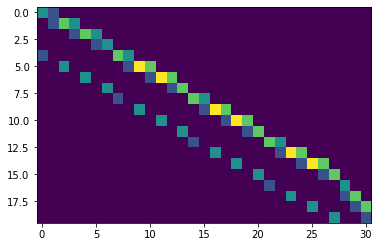

In [12]:
plt.imshow(smat)

In [3]:
# ITE parameters
Z = np.array([[1, 0], [0, -1]])
Y = np.array([[0, -1j], [1j, 0]])
X = np.array([[0, 1], [1, 0]])
Sz = 0.5 * Z
Sy = 0.5 * Y
Sx = 0.5 * X
Opi = [Sx, Sy, Sz]
Opj = [Sx, Sy, Sz]
Op_field = np.eye(d)
timeStep = 0
interactionConstants = [-1] * m

In [4]:
# constructing the dual double-edge factor graph and run BP before running the tSU
pre_graph = defg.defg()
pre_graph = su.TNtoDEFGtransform(pre_graph, tensors_su, weights_su, smat)
s = time.time()
pre_graph.sumProduct(t_max, epsilon, dumping, printTime=1)
pre_tot = time.time() - s
pre_graph.calculateFactorsBeliefs()

BP converged in 26 iterations 


In [5]:
# tSU implementation
errors_su = []
for i in range(iterations):
    tensors_su_next, weights_su_next = su.simpleUpdate(tensors_su,
                                                       weights_su,
                                                       timeStep,
                                                       interactionConstants,
                                                       0,
                                                       Opi,
                                                       Opj,
                                                       Op_field,
                                                       smat,
                                                       D_max,
                                                       'SU',
                                                       graph=None)

    error = np.sum(np.abs(np.asarray(weights_su) - np.asarray(weights_su_next)))
    errors_su.append(error)
    if error < dw:
        print('The final error is: {}'.format(error))
        tensors_su = tensors_su_next
        weights_su = weights_su_next
        break
    tensors_su = tensors_su_next
    weights_su = weights_su_next

/Users/royelkabetz/Git/QBPmodule/SimpleUpdate.py:466: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  leftDim = np.prod(shape[[leftIdx]])
/Users/royelkabetz/Git/QBPmodule/SimpleUpdate.py:467: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rightDim = np.prod(shape[[rightIdx]])


The final error is: 3.817953075476647e-11


In [6]:
# constructing the dual double-edge factor graph and run BP after running the tSU
post_graph = defg.defg()
post_graph = su.TNtoDEFGtransform(post_graph, tensors_su, weights_su, smat)
s = time.time()
post_graph.sumProduct(t_max, epsilon, dumping, printTime=1)
post_tot = time.time() - s
post_graph.calculateFactorsBeliefs()

BP converged in 30 iterations 


In [7]:
# calculating RDMs with BP and SU
rho_SU = []
for i in range(n):
    rho_SU.append(su.singleSiteRDM(i, tensors_su, weights_su, smat))
rho_pre_graph = pre_graph.calculateRDMSfromFactorBeliefs()
rho_post_graph = pre_graph.calculateRDMSfromFactorBeliefs()

In [8]:
# Calculating average trace distances
d_pre_post = 0
d_pre_su = 0
d_post_su = 0
for i in range(n):
    d_pre_post += su.traceDistance(rho_pre_graph[i], rho_pre_graph[i])
    d_pre_su += su.traceDistance(rho_pre_graph[i], rho_SU[i])
    d_post_su += su.traceDistance(rho_post_graph[i], rho_SU[i])

print('\nd(pre, post) = {}\nd(pre, su) = {}\nd(post, su) = {}'.format(d_pre_post / n, d_pre_su / n, d_post_su / n))


d(pre, post) = 0.0
d(pre, su) = 0.00012021684606227986
d(post, su) = 0.00012021684606227986


In [9]:
# Run k SU with ITE iteration  
k = 1
for _ in range(k):
    tensors_su_next, weights_su_next = su.simpleUpdate(tensors_su,
                                                       weights_su,
                                                       0.1,
                                                       interactionConstants,
                                                       0,
                                                       Opi,
                                                       Opj,
                                                       Op_field,
                                                       smat,
                                                       D_max,
                                                       'SU',
                                                       singleEdge=11)
    tensors_su = tensors_su_next
    weights_su = weights_su_next

In [10]:
# calculating new RDMs with BP and SU and trace distances
rho_next_SU = []
for i in range(n):
    rho_next_SU.append(su.singleSiteRDM(i, tensors_su_next, weights_su_next, smat))
d_post_su_next = 0
for i in range(n):
    d_post_su_next += su.traceDistance(rho_post_graph[i], rho_next_SU[i])

print('\nd(pre, post) = {}\nd(pre, su) = {}\nd(post, su) = {}'.format(d_pre_post / n, d_pre_su / n, d_post_su / n))
print('d(post, su-next) = {}'.format(d_post_su_next / n))


d(pre, post) = 0.0
d(pre, su) = 0.00012021684606227986
d(post, su) = 0.00012021684606227986
d(post, su-next) = 0.00021473667994829126


In [11]:
# another tSU implementation
for i in range(iterations):
    tensors_su_next, weights_su_next = su.simpleUpdate(tensors_su,
                                                       weights_su,
                                                       timeStep,
                                                       interactionConstants,
                                                       0,
                                                       Opi,
                                                       Opj,
                                                       Op_field,
                                                       smat,
                                                       D_max,
                                                       'SU',
                                                       graph=None)

    error = np.sum(np.abs(np.asarray(weights_su) - np.asarray(weights_su_next)))
    errors_su.append(error)
    if error < dw:
        print('The final error is: {}'.format(error))
        tensors_su = tensors_su_next
        weights_su = weights_su_next
        break
    tensors_su = tensors_su_next
    weights_su = weights_su_next

The final error is: 8.574931695327197e-11


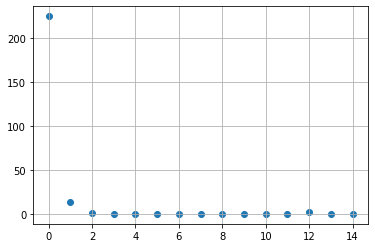

In [12]:
# plot the convergence of weights error between consecutive tSU iterations
plt.figure()
plt.scatter(range(len(errors_su[:])), errors_su[:])
plt.grid()
plt.show()